# League of Legends Pro-Players performance trends compared in off-seasons and tournaments.

## Project Details

### Purpose
This project aims to **analyze and compare the performance of professional League of Legends players** in two distinct competitive environments: **off-season games** and **official tournament matches**. By evaluating differences in measurable performance metrics across both contexts, the goal is to identify **whether players exhibit statistically significant variations** in gameplay behavior depending on match type.

---

### Performance Metrics

The following metrics are used to assess and compare the individual performance of pro players:

1. **Kill/Death/Assist (KDA) Ratio** – Represents a player's combat efficiency, calculated as *(Kills + Assists) / Deaths*. A higher KDA generally indicates more impactful play and fewer mistakes.

2. **Damage Dealt** – Measures the total damage a player inflicts on enemy champions, providing insight into their offensive contribution.

3. **Gold Earned per Minute (GPM)** – Captures how efficiently a player generates gold throughout a match, often through farming and objective control.

4. **Creep Score (CS)** – Tracks the number of minions or neutral monsters a player kills. It's a core indicator of farming ability and overall resource acquisition.

5. **Custom Performance Score** – A weighted metric created for this project to combine multiple in-game statistics (KDA, CS/min, damage/min, gold/min, and win outcome) into a single performance indicator.

---

### Commonly Used Terms

- **Summoner** – Refers to the player.
- **Champion** – Refers to the character the player controls in-game.
- **Farming** – The act of killing minions or neutral monsters to gain gold and CS.

---

### Role Context

In League of Legends, each team consists of five unique roles:

- **Top Laner**
- **Jungler**
- **Mid Laner**
- **AD Carry (ADC)**
- **Support**

For the purpose of this analysis, the **Support role has been excluded**. Unlike other roles, support performance relies more on **team coordination, vision control, and utility**, rather than individually quantifiable metrics like KDA, CS, or gold. As such, this project focuses on roles with **clear, performance-driven statistics**.

---

### Selected Pro Players

The following players were selected based on their prominence, availability of data, and diversity across **roles, regions, and leagues**:

| Player        | Role       | Region         | League | Team             | Summoner / Account Name     |
|---------------|------------|----------------|--------|------------------|-----------------------------|
| **Faker**     | Mid Laner  | South Korea    | LCK    | T1               | Hide on bush                |
| **Chovy**     | Mid Laner  | South Korea    | LCK    | Gen.G            | 허거덩                       |
| **Ruler**     | ADC        | South Korea    | LPL    | JD Gaming        | 귀찮게하지마                 |
| **Caps**      | Mid Laner  | Denmark        | LEC    | G2 Esports       | G2 Caps                     |
| **Blaber**    | Jungler    | United States  | LCS    | Cloud9           | blaberfish2                 |
| **Zeus**      | Top Laner  | South Korea    | LCK    | T1               | Zeus10                      |
| **Hans Sama** | ADC        | France         | LEC    | G2 Esports       | G2 Hans Sama                |

These players represent a broad range of styles and strengths, providing a rich dataset for **cross-role**, **cross-league**, and **cross-contextual** performance comparison.


## 1. Import Libraries
We'll begin by importing the libraries needed for data analysis and visualization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Gathering and Organizing the Scraped Data

The data was collected from the following sources:

1. **Riot Games League of Legends Client**  
2. **[OP.GG](https://op.gg/lol)** — primarily used for collecting off-season match data  
3. **Riot Games Developer API** — used to retrieve match histories and performance statistics  
4. **[LoL Fandom Wiki](https://lol.fandom.com/wiki)** — primarily used for gathering tournament match data

Each player's match history was compiled into two CSV files, one for **off-season** and one for **tournament** games. These files are stored in the `data/` directory of the project.

- A total of **14 CSV files** were created (2 per player × 7 players).
- Each file contains data from **10 matches**, ensuring consistency and comparability.
- For **tournament games**, only the **first match of each series** (e.g., best-of-3 or best-of-5) was considered in order to avoid introducing skill bias from repetitive matchups against the same team.


# 3. Process the data in the CSV files for each player 

### The following code is responsible for importing, separating, enriching, and combining all CSV files. This processing step prepares the dataset for subsequent Exploratory Data Analysis (EDA) and hypothesis testing.


In [25]:
def enrich_player_data(filepath, player_name, match_type):
    df = pd.read_csv(filepath)
    
    # function to convert game time from its current format to something that can divide
    def parse_game_time(time_str):
        min_part, sec_part = time_str.strip().upper().split("M")
        minutes = int(min_part.strip())
        seconds = int(sec_part.replace("S", "").strip())
        return minutes + seconds / 60

    # Overall enrichment of the data using gametime, and making a personal performance indicator to use to compare
    df['GameMinutes'] = df['Game Time'].apply(parse_game_time)
    df['KDA'] = (df['Kills'] + df['Assists']) / df['Deaths'].replace(0, 1) # Calculate KDA, 0 becomes 1 to avoid division by zero, AKA Perfect KDA
    df['CS_per_min'] = df['CS'] / df['GameMinutes'] # Enrichment by converting CS to CS per minute
    df['Damage_per_min'] = df['Damage'] / df['GameMinutes'] # Enrichment by converting Damage to Damage per minute
    df['Gold_per_min'] = df['Gold'] / df['GameMinutes'] # Enrichment by converting Gold Earned to GE per minute
    df['Win'] = df['Win/Loss'].apply(lambda x: 1 if x.lower() == 'win' else 0) # Converting Win/Loss to 1/0 respectively

    # Safely ignore missing columns like Performance(OP.GG) because tournament CSV's dont contain data from OP.GG
    if 'Performance(OP.GG)' in df.columns:
        df.drop(columns=['Performance(OP.GG)'], inplace=True)

    # Creating a personal performance indicator giving weightage to different metrics
    df['PerformanceScore'] = ( 
        df['KDA'] * 0.3 +
        df['CS_per_min'] * 0.2 +
        df['Damage_per_min'] * 0.2 +
        df['Gold_per_min'] * 0.2 +
        df['Win'] * 0.1
    )
    df['Player'] = player_name
    df['MatchType'] = match_type
    return df

# Calling above function to enrich each player's DataFrame
faker_off = enrich_player_data("data/faker_offseason_games.csv", "Faker", "Offseason")
faker_tourn = enrich_player_data("data/faker_tournament_games.csv", "Faker", "Tournament")

chovy_off = enrich_player_data("data/chovy_offseason_games.csv", "Chovy", "Offseason")
chovy_tourn = enrich_player_data("data/chovy_tournament_games.csv", "Chovy", "Tournament")

ruler_off = enrich_player_data("data/ruler_offseason_games.csv", "Ruler", "Offseason")
ruler_tourn = enrich_player_data("data/ruler_tournament_games.csv", "Ruler", "Tournament")

caps_off = enrich_player_data("data/caps_offseason_games.csv", "Caps", "Offseason")
caps_tourn = enrich_player_data("data/caps_tournament_games.csv", "Caps", "Tournament")

blaber_off = enrich_player_data("data/blaber_offseason_games.csv", "Blaber", "Offseason")
blaber_tourn = enrich_player_data("data/blaber_tournament_games.csv", "Blaber", "Tournament")

zeus_off = enrich_player_data("data/zeus_offseason_games.csv", "Zeus", "Offseason")
zeus_tourn = enrich_player_data("data/zeus_tournament_games.csv", "Zeus", "Tournament")

hanssama_off = enrich_player_data("data/hanssama_offseason_games.csv", "Hans Sama", "Offseason")
hanssama_tourn = enrich_player_data("data/hanssama_tournament_games.csv", "Hans Sama", "Tournament")

# Combine into grouped dataframes
offseason_df = pd.concat([
    faker_off, chovy_off, ruler_off, caps_off, blaber_off, zeus_off, hanssama_off
], ignore_index=True)

tournament_df = pd.concat([
    faker_tourn, chovy_tourn, ruler_tourn, caps_tourn, blaber_tourn, zeus_tourn, hanssama_tourn
], ignore_index=True)

# final dataframe containing all 140 datasets
all_games_df = pd.concat([offseason_df, tournament_df], ignore_index=True)

# Checking if everything is loaded correctly
print("All games loaded:", all_games_df.shape[0]) 
print(all_games_df['MatchType'].value_counts())

# Displaying 20 games for each player in a table format
for player in all_games_df['Player'].unique():
    print(f"\n=== {player} ===")
    display(all_games_df[all_games_df['Player'] == player])


All games loaded: 140
MatchType
Offseason     70
Tournament    70
Name: count, dtype: int64

=== Faker ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
0,1,Jayce,12,2,7,327,70810,21258,Win,40M 09S,40.150000,9.500000,8.144458,1763.636364,529.464508,1,463.199066,Faker,Offseason
1,2,Viktor,12,4,10,214,37472,13272,Win,26M 41S,26.683333,5.500000,8.019988,1404.322299,497.389132,1,383.696284,Faker,Offseason
2,3,Orianna,5,4,4,220,23306,10333,Loss,23M 48S,23.800000,2.250000,9.243697,979.243697,434.159664,0,285.204412,Faker,Offseason
3,4,Yone,4,7,16,234,29644,13445,Win,29M 41S,29.683333,2.857143,7.883212,998.674902,452.947782,1,292.858322,Faker,Offseason
4,5,Yone,5,4,4,266,24291,13105,Loss,28M 28S,28.466667,2.250000,9.344262,853.313817,460.362998,0,265.279215,Faker,Offseason
5,6,Sylas,3,4,11,180,22045,9443,Loss,26M 04S,26.066667,3.500000,6.905371,845.716113,362.263427,0,244.026982,Faker,Offseason
6,7,Sylas,3,6,8,290,22854,13932,Loss,38M 33S,38.550000,1.833333,7.522698,592.840467,361.400778,0,192.902789,Faker,Offseason
7,8,Viktor,7,3,10,207,25315,11464,Win,23M 59S,23.983333,5.666667,8.630994,1055.524670,477.998610,1,310.230855,Faker,Offseason
8,9,Sylas,3,5,5,236,20173,11499,Loss,28M 26S,28.433333,1.600000,8.300117,709.484174,404.419695,0,224.920797,Faker,Offseason
9,10,Galio,2,5,11,206,16990,10926,Loss,26M 52S,26.866667,2.600000,7.667494,632.382134,406.674938,0,210.124913,Faker,Offseason



=== Chovy ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
10,1,Azir,6,8,6,209,23492,9576,Loss,25M 32S,25.533333,1.500000,8.185379,920.052219,375.039164,0,261.105352,Chovy,Offseason
11,2,Zoe,12,6,12,201,37663,12593,Win,30M 45S,30.750000,4.000000,6.536585,1224.813008,409.528455,1,329.475610,Chovy,Offseason
12,3,Corki,9,6,8,266,35799,14562,Win,29M 46S,29.766667,2.833333,8.936170,1202.653975,489.204927,1,341.109015,Chovy,Offseason
13,4,Ahri,6,2,11,246,25873,12507,Win,25M 07S,25.116667,8.500000,9.794293,1030.112807,497.956204,1,310.222661,Chovy,Offseason
14,5,Zoe,3,1,6,133,13753,7121,Win,15M 37S,15.616667,9.000000,8.516542,880.661686,455.987193,1,271.833084,Chovy,Offseason
15,6,Corki,3,10,5,335,43207,15366,Loss,36M 20S,36.333333,0.800000,9.220183,1189.183486,422.917431,0,324.504220,Chovy,Offseason
16,7,Xin Zhao,6,3,3,132,10453,7814,Win,19M 33S,19.550000,3.000000,6.751918,534.680307,399.693095,1,189.225064,Chovy,Offseason
17,8,Viktor,6,5,10,215,29290,12959,Win,27M 33S,27.550000,3.200000,7.803993,1063.157895,470.381125,1,309.328603,Chovy,Offseason
18,9,Jax,10,9,15,271,46416,17726,Loss,45M 20S,45.333333,2.777778,5.977941,1023.882353,391.014706,0,285.008333,Chovy,Offseason
19,10,Sylas,18,10,11,225,59942,16088,Win,33M 04S,33.066667,2.900000,6.804435,1812.762097,486.532258,1,462.189758,Chovy,Offseason



=== Ruler ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
20,1,Kaisa,9,7,10,296,34003,17579,Win,32M 43S,32.716667,2.714286,9.047376,1039.317371,537.310239,1,318.049283,Ruler,Offseason
21,2,Kalista,8,3,8,142,19623,9798,Win,18M 25S,18.416667,5.333333,7.710407,1065.502262,532.018100,1,322.746154,Ruler,Offseason
22,3,Jhin,1,3,3,95,7800,5146,Loss,15M 31S,15.516667,1.333333,6.122449,502.685285,331.643394,0,168.490226,Ruler,Offseason
23,4,Xayah,16,6,12,308,50511,16470,Win,29M 41S,29.683333,4.666667,10.376193,1701.661988,554.856822,1,454.879001,Ruler,Offseason
24,5,Ezreal,8,1,4,173,21703,10586,Win,18M 32S,18.533333,12.000000,9.334532,1171.025180,571.187050,1,354.009353,Ruler,Offseason
25,6,Varus,4,1,3,170,10001,9075,Win,17M 36S,17.600000,7.000000,9.659091,568.238636,515.625000,1,220.904545,Ruler,Offseason
26,7,Ezreal,4,3,6,181,15155,8573,Win,20M 31S,20.516667,3.333333,8.822096,738.667750,417.855402,1,234.169050,Ruler,Offseason
27,8,Varus,16,10,7,288,50033,18988,Loss,38M 40S,38.666667,2.300000,7.448276,1293.956897,491.068966,0,359.184828,Ruler,Offseason
28,9,Kaisa,13,9,10,321,50482,17760,Win,30M 49S,30.816667,2.555556,10.416441,1638.139535,576.311520,1,445.840166,Ruler,Offseason
29,10,Kaisa,1,4,2,180,8255,8002,Loss,20M 36S,20.600000,0.750000,8.737864,400.728155,388.446602,0,159.807524,Ruler,Offseason



=== Caps ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
30,1,Ryze,3,2,12,205,25098,11244,Win,28M 05S,28.083333,7.500000,7.299703,893.697329,400.379822,1,262.625371,Caps,Offseason
31,2,Ryze,7,5,7,142,12229,8980,Win,19M 35S,19.583333,2.800000,7.251064,624.459574,458.553191,1,218.992766,Caps,Offseason
32,3,Syndra,4,1,10,233,24047,12243,Win,24M 25S,24.416667,14.000000,9.542662,984.860068,501.419795,1,303.464505,Caps,Offseason
33,4,Azir,8,10,11,289,33254,16789,Loss,43M 54S,43.900000,1.900000,6.583144,757.494305,382.437358,0,229.872961,Caps,Offseason
34,5,Taliyah,2,6,4,217,13974,9733,Loss,27M 12S,27.200000,1.000000,7.977941,513.750000,357.830882,0,176.211765,Caps,Offseason
35,6,Aurora,14,6,8,225,45407,16223,Win,32M 05S,32.083333,3.666667,7.012987,1415.283117,505.651948,1,386.789610,Caps,Offseason
36,7,Zed,7,9,4,172,15768,10854,Loss,28M 32S,28.533333,1.222222,6.028037,552.616822,380.397196,0,188.175078,Caps,Offseason
37,8,Taliyah,10,7,12,267,25916,16051,Win,34M 34S,34.566667,3.142857,7.724204,749.739634,464.349084,1,245.405442,Caps,Offseason
38,9,Viktor,1,6,0,107,4641,4603,Loss,15M 12S,15.200000,0.166667,7.039474,305.328947,302.828947,0,123.089474,Caps,Offseason
39,10,Gragas,6,8,2,179,17997,10269,Loss,24M 54S,24.900000,1.000000,7.188755,722.771084,412.409639,0,228.773896,Caps,Offseason



=== Blaber ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
40,1,Khazix,6,3,10,194,16528,11014,Win,24M 21S,24.350000,5.333333,7.967146,678.767967,452.320329,1,229.511088,Blaber,Offseason
41,2,Viego,10,9,5,193,20011,13504,Loss,29M 28S,29.466667,1.666667,6.549774,679.106335,458.280543,0,229.287330,Blaber,Offseason
42,3,Vi,8,3,10,229,19827,13843,Win,28M 57S,28.950000,6.000000,7.910190,684.870466,478.169257,1,236.089983,Blaber,Offseason
43,4,Lilliah,11,5,12,290,39073,17055,Win,32M 29S,32.483333,4.600000,8.927655,1202.863007,525.038481,1,348.845829,Blaber,Offseason
44,5,Pantheon,9,3,5,195,21320,11977,Win,26M 20S,26.333333,4.666667,7.405063,809.620253,454.822785,1,255.869620,Blaber,Offseason
45,6,Nidalee,9,4,17,186,28925,12391,Loss,29M 28S,29.466667,6.500000,6.312217,981.617647,420.509050,0,283.637783,Blaber,Offseason
46,7,Viego,5,9,2,192,16734,12247,Loss,27M 59S,27.983333,0.777778,6.861227,597.998809,437.653365,0,208.736014,Blaber,Offseason
47,8,Naafiri,5,4,7,198,15622,12066,Loss,28M 05S,28.083333,3.000000,7.050445,556.272997,429.649852,0,199.494659,Blaber,Offseason
48,9,Lilliah,10,2,1,122,11684,7908,Win,15M 16S,15.266667,5.500000,7.991266,765.327511,517.991266,1,260.012009,Blaber,Offseason
49,10,Zyra,3,1,11,155,10730,8335,Win,18M 04S,18.066667,14.000000,8.579336,593.911439,461.346863,1,217.067528,Blaber,Offseason



=== Zeus ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
50,1,Mordekaiser,8,9,15,277,47959,16946,Win,43M 03S,43.050000,2.555556,6.434379,1114.030197,393.635308,1,303.686643,Zeus,Offseason
51,2,Renekton,2,5,2,175,18145,7392,Loss,29M 52S,29.866667,0.800000,5.859375,607.533482,247.500000,0,172.418571,Zeus,Offseason
52,3,Sion,5,8,6,210,20303,11788,Win,28M 53S,28.883333,1.375000,7.270629,702.931333,408.124639,1,224.177820,Zeus,Offseason
53,4,Sion,1,7,5,216,20846,10833,Loss,27M 42S,27.700000,0.857143,7.797834,752.563177,391.083032,0,230.545952,Zeus,Offseason
54,5,Renekton,3,9,3,207,20647,11264,Loss,28M 29S,28.483333,0.666667,7.267408,724.880047,395.459333,0,225.721358,Zeus,Offseason
55,6,Akali,6,8,9,190,31174,11613,Win,29M 41S,29.683333,1.875000,6.400898,1050.218978,391.229646,1,290.232405,Zeus,Offseason
56,7,Akali,13,3,10,239,36963,15587,Win,34M 01S,34.016667,7.666667,7.025968,1086.614405,458.216561,1,312.771387,Zeus,Offseason
57,8,Viktor,4,5,2,181,21054,9380,Loss,21M 43S,21.716667,1.200000,8.334612,969.485802,431.926324,0,282.309348,Zeus,Offseason
58,9,Ambessa,9,5,6,347,44664,18630,Win,36M 09S,36.150000,3.000000,9.598893,1235.518672,515.352697,1,353.094053,Zeus,Offseason
59,10,Ambessa,7,3,7,267,36538,14569,Win,30M 49S,30.816667,4.666667,8.664143,1185.657112,472.763656,1,334.916982,Zeus,Offseason



=== Hans Sama ===


,Game,Champion,Kills,Deaths,Assists,CS,Damage,Gold,Win/Loss,Game Time,GameMinutes,KDA,CS_per_min,Damage_per_min,Gold_per_min,Win,PerformanceScore,Player,MatchType
60,1,Ezreal,9,9,8,292,56969,16288,Loss,39M 10S,39.166667,1.888889,7.455319,1454.527660,415.863830,0,376.136028,Hans Sama,Offseason
61,2,Galio,8,5,18,286,34633,15337,Win,34M 57S,34.950000,5.200000,8.183119,990.929900,438.826896,1,289.247983,Hans Sama,Offseason
62,3,Varus,6,11,5,146,16763,9621,Loss,24M 54S,24.900000,1.000000,5.863454,673.212851,386.385542,0,213.392369,Hans Sama,Offseason
63,4,Tristana,1,6,10,356,20843,17031,Loss,43M 54S,43.900000,1.833333,8.109339,474.783599,387.949886,0,174.718565,Hans Sama,Offseason
64,5,Tristana,5,4,2,147,13329,9033,Win,15M 33S,15.550000,1.750000,9.453376,857.170418,580.900322,1,290.129823,Hans Sama,Offseason
65,6,Tristana,3,3,2,176,13172,8336,Loss,20M 34S,20.566667,1.666667,8.557536,640.453809,405.316045,0,211.365478,Hans Sama,Offseason
66,7,Zeri,6,7,14,338,34938,17965,Loss,37M 24S,37.400000,2.857143,9.037433,934.171123,480.347594,0,285.568373,Hans Sama,Offseason
67,8,Tristana,8,2,8,152,15935,9116,Win,18M 45S,18.750000,8.000000,8.106667,849.866667,486.186667,1,271.332000,Hans Sama,Offseason
68,9,Ezreal,5,6,3,144,18020,7859,Loss,21M 03S,21.050000,1.333333,6.840855,856.057007,373.349169,0,247.649406,Hans Sama,Offseason
69,10,Varus,8,4,6,290,28834,15246,Loss,33M 05S,33.083333,3.500000,8.765743,871.556675,460.836272,0,269.281738,Hans Sama,Offseason


## 4. Exploratory Data Analysis (EDA)

In this step, we analyze trends and patterns within the combined dataset using summary statistics and visualizations.

In [44]:
#describe the overall data in textual format so we can notice patterns and decide what to show visually

display(all_games_df.describe())
all_games_df.groupby('MatchType')[['PerformanceScore', 'KDA', 'CS_per_min', 'Damage_per_min', 'Deaths']].mean()

             Game       Kills      Deaths     Assists          CS  \
count  140.000000  140.000000  140.000000  140.000000  140.000000   
mean     5.500000    5.514286    3.628571    7.164286  251.964286   
std      2.882595    3.678610    2.829299    3.779176   72.575380   
min      1.000000    0.000000    0.000000    0.000000   95.000000   
25%      3.000000    3.000000    1.000000    5.000000  205.750000   
50%      5.500000    5.000000    3.000000    7.000000  245.000000   
75%      8.000000    8.000000    6.000000   10.000000  290.000000   
max     10.000000   18.000000   11.000000   18.000000  539.000000   

             Damage          Gold  GameMinutes         KDA  CS_per_min  \
count    140.000000    140.000000   140.000000  140.000000  140.000000   
mean   24446.914286  13285.921429    30.159167    5.733328    8.342890   
std    11954.958391   3773.092736     7.150448    4.719320    1.236331   
min     4641.000000   4603.000000    15.200000    0.142857    5.859375   
25%    1

,PerformanceScore,KDA,CS_per_min,Damage_per_min,Deaths
MatchType,,,,,
Offseason,274.073921,3.716995,7.887053,913.422025,5.328571
Tournament,230.528830,7.749660,8.798727,692.952675,1.928571


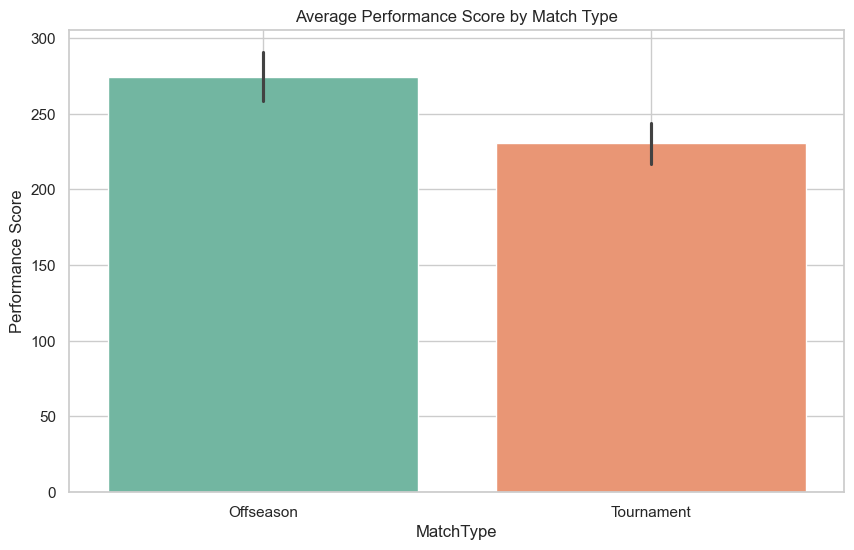

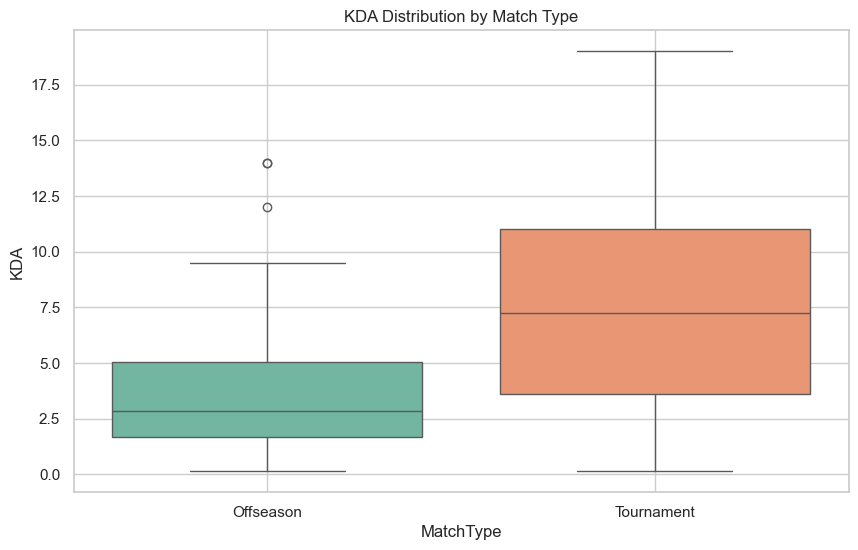

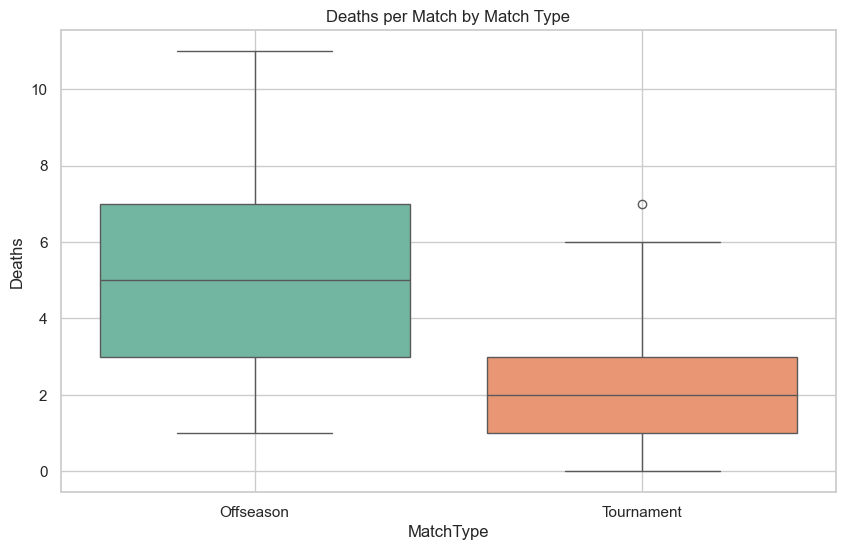

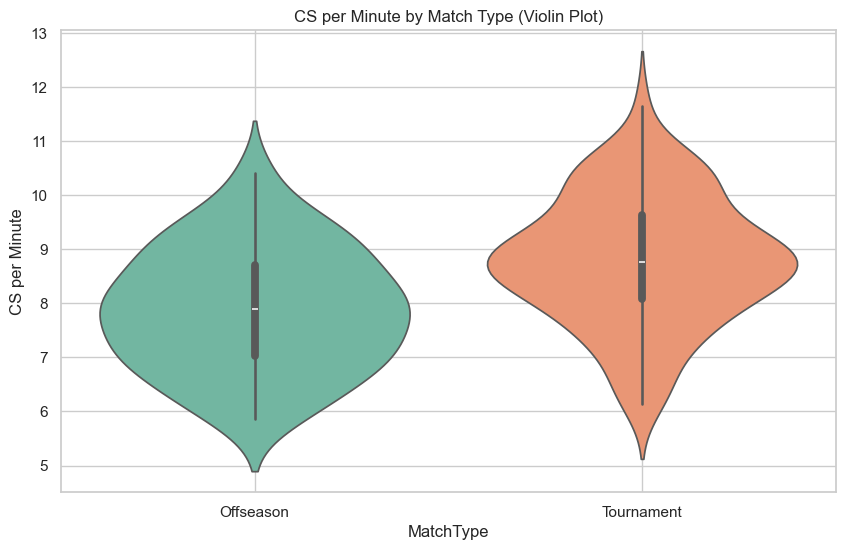

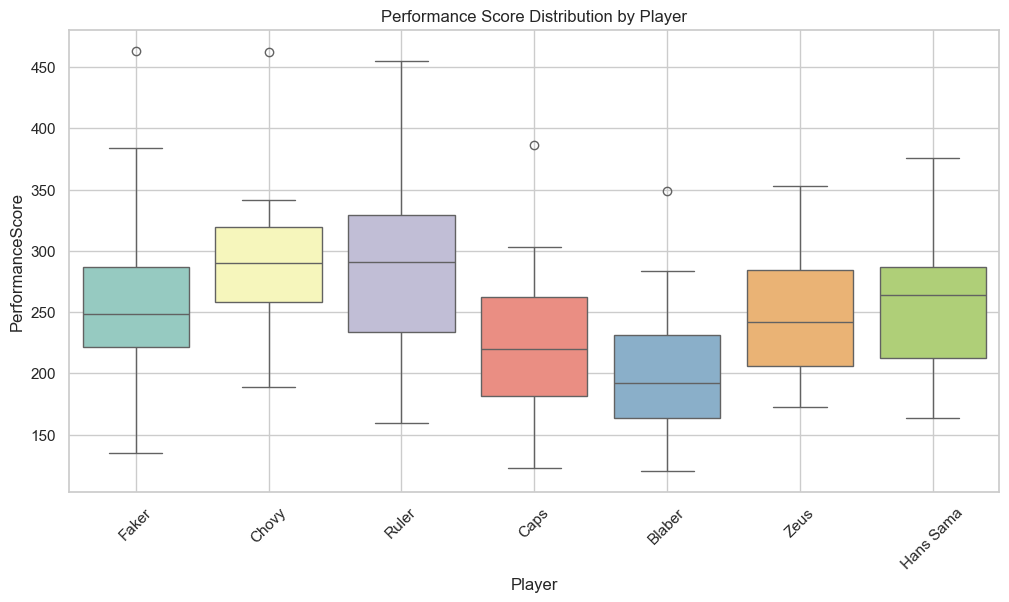

In [ ]:
# setting the style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Barplot – Average Performance Score by Match Type
plt.figure()
sns.barplot(data=all_games_df, x="MatchType", y="PerformanceScore", hue="MatchType", legend=False, palette="Set2")
plt.title("Average Performance Score by Match Type")
plt.ylabel("Performance Score")
plt.grid(True)
plt.show()

# Boxplot – KDA Distribution by Match Type
plt.figure()
sns.boxplot(data=all_games_df, x="MatchType", y="KDA", hue="MatchType", legend=False, palette="Set2")
plt.title("KDA Distribution by Match Type")
plt.grid(True)
plt.show()

# Boxplot – Deaths Distribution by Match Type
plt.figure()
sns.boxplot(data=all_games_df, x="MatchType", y="Deaths", hue="MatchType", legend=False, palette="Set2")
plt.title("Deaths per Match by Match Type")
plt.grid(True)
plt.show()

# Violinplot - CSPM by Match Type
plt.figure()
sns.violinplot(data=all_games_df, x="MatchType", y="CS_per_min", hue="MatchType", legend=False, palette="Set2")
plt.title("CS per Minute by Match Type (Violin Plot)")
plt.ylabel("CS per Minute")
plt.grid(True)
plt.show()

# Boxplot - Performance Score by Player (combined)
plt.figure(figsize=(12,6))
sns.boxplot(data=all_games_df, x="Player", y="PerformanceScore", hue="Player", legend=False, palette="Set3")
plt.title("Performance Score Distribution by Player")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### EDA Summary

The visualizations above highlight key differences between off-season and tournament matches, as well as variability across individual players:

- Players tend to have **higher performance scores** during off-season games, suggesting more aggressive or less risk-averse play.
- **KDA is higher** during tournaments, likely due to more careful and coordinated strategies.
- The number of **deaths per match is significantly lower** during tournaments, supporting the hypothesis that players adopt safer playstyles under competitive pressure.
- The **CS per minute violin plot** shows that players generally farm slightly more efficiently during tournament matches.
- The **performance score distribution by player** reveals clear variability in performance styles and consistency. Players like **Ruler** and **Chovy** exhibit higher median performance scores compared to others like **Blaber** and **Caps**.

These observed patterns set the stage for formal hypothesis testing in the next section.


## 5. Hypothesis Testing

### Hypothesis 1 – Main Hypothesis: Performance Score Comparison

We aim to test whether there is a significant difference in the average **performance score** between off-season and tournament matches.

- **Null Hypothesis:** There is no significant difference in the average performance score between off-season and tournament games.
- **Alternative Hypothesis:** There is a significant difference in the average performance score between off-season and tournament games.

This is a **two-tailed hypothesis test**, and we will use an **independent samples t-test** to evaluate it, assuming the two groups are independent and drawn from approximately normal distributions.


In [ ]:
from scipy.stats import ttest_ind

# Separating the performance scores based on match type
offseason_scores = all_games_df[all_games_df['MatchType'] == "Offseason"]['PerformanceScore']
tournament_scores = all_games_df[all_games_df['MatchType'] == "Tournament"]['PerformanceScore']

# Perform independent two-sample t-test, no assumption of equal variance
t_stat, p_val = ttest_ind(offseason_scores, tournament_scores, equal_var=False)

# Print the relevant results
print("Mean Performance Score (Offseason):", offseason_scores.mean())
print("Mean Performance Score (Tournament):", tournament_scores.mean())
print("T-statistic:", round(t_stat, 3))
print("P-value:", round(p_val, 5))

# Reject/Accept according to the results
alpha = 0.05  # standard level of significance
if p_val < alpha:
    print("\nResult: Reject the null hypothesis (significant difference exists).")
else:
    print("\nResult: Fail to reject the null hypothesis (no significant difference).")


Mean Performance Score (Offseason): 274.07392076111137
Mean Performance Score (Tournament): 230.52882990975857
T-statistic: 3.872
P-value: 0.00017

Result: Reject the null hypothesis (significant difference exists).


### Hypothesis 1 Result: Performance Score Comparison

An independent two-sample t-test was conducted to compare the average **performance scores** of players in **off-season** and **tournament** matches.

- **T-statistic**: 3.872
- **P-value**: 0.00017

Since the p-value is well below the standard significance level of 0.05, we **reject the null hypothesis**. This indicates that there is a **statistically significant difference** in average performance scores between off-season and tournament games.

**Interpretation:**  
Players tend to perform **differently** in off-season matches compared to tournament matches when evaluated using our custom performance metric. This supports the hypothesis that match context (casual vs. competitive) influences overall gameplay behavior.


### Hypothesis 2 – Additional Hypothesis: Death Rate Comparison

We aim to test whether there is a significant difference in the average **number of deaths** between off-season and tournament matches.

- **Null Hypothesis:** There is no significant difference in the average number of deaths per game between off-season and tournament matches.
- **Alternative Hypothesis:** There is a significant difference in the average number of deaths per game between off-season and tournament matches.

This is a **two-tailed hypothesis test**, using an **independent samples t-test** to compare the mean number of deaths between the two match types.


In [61]:
from scipy.stats import ttest_ind

#  Separating the death values by match type
offseason_deaths = all_games_df[all_games_df['MatchType'] == "Offseason"]['Deaths']
tournament_deaths = all_games_df[all_games_df['MatchType'] == "Tournament"]['Deaths']

# Perform independent two-sample t-test
t_stat2, p_val2 = ttest_ind(offseason_deaths, tournament_deaths, equal_var=False)

# Print the re;evant results
print("Average Deaths (Offseason):", round(offseason_deaths.mean(), 3))
print("Average Deaths (Tournament):", round(tournament_deaths.mean(), 3))
print("T-statistic:", round(t_stat2, 3))
print("P-value:", round(p_val2, 5))


# Reject/Accept according to the results
alpha = 0.05  
if p_val2 < alpha:
    print("\nResult: Reject the null hypothesis (significant difference exists in death rate).")
else:
    print("\nResult: Fail to reject the null hypothesis (no significant difference in death rate).")


Average Deaths (Offseason): 5.329
Average Deaths (Tournament): 1.929
T-statistic: 8.88
P-value: 0.0

Result: Reject the null hypothesis (significant difference exists in death rate).


### Hypothesis 2 Result: Death Rate Comparison

To determine whether players die significantly less during tournament matches, we performed an independent two-sample t-test comparing the average number of deaths per game in off-season and tournament matches.

- **Average Deaths (Offseason):** 5.329  
- **Average Deaths (Tournament):** 1.929  
- **T-statistic:** 8.88  
- **P-value:** < 0.00001

Since the p-value is well below the 0.05 significance threshold, we **reject the null hypothesis**. This confirms that there is a **statistically significant difference in death rates** between match types.

**Interpretation:**  
Players die significantly less often in **tournament matches** compared to **off-season games**. This supports the idea that in competitive settings, players adopt a more careful and strategic playstyle to reduce risks.


### Hypothesis 3 – Additional Hypothesis: CS per Minute Comparison

We aim to test whether there is a significant difference in the average **CS per minute (Creep Score per Minute)** between off-season and tournament matches.

- **Null Hypothesis:** There is no significant difference in the average CS per minute between off-season and tournament matches.
- **Alternative Hypothesis:** There is a significant difference in the average CS per minute between off-season and tournament matches.

This is a **two-tailed hypothesis test**, using an independent samples t-test to compare average CS/min between the two match types.


In [62]:
from scipy.stats import ttest_ind

# Separating the CS/min values by match type
offseason_cs = all_games_df[all_games_df['MatchType'] == "Offseason"]['CS_per_min']
tournament_cs = all_games_df[all_games_df['MatchType'] == "Tournament"]['CS_per_min']

# Run the t-test
t_stat3, p_val3 = ttest_ind(offseason_cs, tournament_cs, equal_var=False)

#print the mean of both offseason and tournament cs value
print("Average CS/min (Offseason):", round(offseason_cs.mean(), 3))
print("Average CS/min (Tournament):", round(tournament_cs.mean(), 3))
# Output the t-test results
print("\nT-statistic:", round(t_stat3, 3))
print("P-value:", round(p_val3, 5))

# Interpret the result
alpha = 0.05
if p_val3 < alpha:
    print("\nResult: Reject the null hypothesis (significant difference exists in CS per minute).")
else:
    print("\nResult: Fail to reject the null hypothesis (no significant difference in CS per minute).")


Average CS/min (Offseason): 7.887
Average CS/min (Tournament): 8.799

T-statistic: -4.679
P-value: 1e-05

Result: Reject the null hypothesis (significant difference exists in CS per minute).


### Hypothesis 3 Result: CS per Minute Comparison

An independent two-sample t-test was conducted to compare the average **CS per minute** between off-season and tournament matches.

- **Average CS/min (Offseason):** 7.887  
- **Average CS/min (Tournament):** 8.799  
- **T-statistic:** -4.679  
- **P-value:** 1e-05

Since the p-value is far below the 0.05 significance threshold, we **reject the null hypothesis**. This indicates that there is a **statistically significant difference in CS per minute** between off-season and tournament games.

**Interpretation:**  
Players farm **more efficiently during tournament matches**. This may reflect more focused laning strategies, better coordination with team objectives, or simply higher discipline and prioritization of gold income during official competitive play.


## Conclusion

This project analyzed the in-game performance of seven professional League of Legends players across 140 matches, split evenly between off-season and tournament games. Using a custom-built performance score and other key gameplay metrics such as KDA, deaths, and CS per minute, the goal was to uncover statistical differences in player behavior across different match contexts.

Three hypotheses were tested:

- **Hypothesis 1:** Players have significantly different overall performance scores in off-season vs tournament matches. *Supported*
- **Hypothesis 2:** Players die significantly less in tournament matches. *Strongly supported*
- **Hypothesis 3:** Players have significantly different CS per minute between match types. *Supported*

These results highlight a measurable shift in playstyle between casual and competitive environments. Tournament matches are characterized by safer, more efficient gameplay — with higher KDA, fewer deaths, and better farming — suggesting that pro players adapt their strategies significantly in high-stakes settings.

Overall, the project demonstrates how structured data analysis can reveal deeper trends in esports performance, and serves as a model for applying hypothesis-driven data science in competitive gaming contexts.
